# Testing batdetect2 pipeline features:

## **Working on features relevant to the use of this pipeline on recovered Audiomoth .wav recordings**

## 1) Figuring out our imports:

### a) Below are the imports pertaining to accessing data and metadata

In [1]:
from pathlib import Path
import glob
import exiftool
import soundfile as sf

### b) Below are the imports pertaining to data manipulation

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

### c) Below are the imports pertaining to data visualization

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt

### d) Below are the imports pertaining to the use of the MSDS pipeline

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from cfg import get_config

## 2) For our current project requirements, we read in batdetect2 outputs to compile # of detections per 30-min intervals

In [5]:
dets = pd.read_csv(f'../output_dir/recover-20230809/Telephone Field/bd2__recover-20230809_UBNA_010.csv')
dets['ref_time'] = pd.to_datetime(dets['input_file'], format="%Y%m%d_%H%M%S", exact=False)
dets_per_file = dets.groupby(['ref_time'])['ref_time'].count()

num_dets = pd.read_csv(f'../output_dir/recover-20230809/Telephone Field/activity__recover-20230809_UBNA_010.csv', index_col=0)
num_dets.set_index('date_and_time_UTC', inplace=True)
num_dets

,num_of_detections
date_and_time_UTC,
2023-08-02 03:00:00+00:00,1
2023-08-02 03:30:00+00:00,1
2023-08-02 04:00:00+00:00,7
2023-08-02 04:30:00+00:00,31
2023-08-02 05:00:00+00:00,22
...,...
2023-08-09 11:00:00+00:00,1
2023-08-09 11:30:00+00:00,1
2023-08-09 12:00:00+00:00,74


## 3) These results are saved as dataframes to allow easy manipulation

In [6]:
activity_datetimes = pd.to_datetime(num_dets.index.values)
raw_dates = activity_datetimes.strftime("%m/%d/%y")
raw_times = activity_datetimes.strftime("%H:%M")

col_name = f"num_of_detections"
data = list(zip(raw_dates, raw_times, num_dets[col_name]))
activity = pd.DataFrame(data, columns=["Date (UTC)", "Time (UTC)", col_name])
activity_df = activity.pivot(index="Time (UTC)", columns="Date (UTC)", values=col_name)
activity_df

Date (UTC),08/02/23,08/03/23,08/04/23,08/05/23,08/06/23,08/07/23,08/08/23,08/09/23
Time (UTC),,,,,,,,
03:00,1,1,1,1,1,1,1,1
03:30,1,1,1,1,7,1,1,1
04:00,7,120,29,24,29,23,422,269
04:30,31,185,29,4,43,148,9,1
05:00,22,25,13,5,2,2,1,23
05:30,60,1,1,1,1,2,1,10
06:00,3,1,72,1,1,19,8,12
06:30,62,67,1,10,2,2,10,1
07:00,95,78,1,1,35,1,9,136


## 4) A later addition to this repository was `src/file_dealer.py` which assembles a comprehensive summary of all collected records from a given hard drive

In [80]:
cfg = dict()
cfg["input_dir"] = f'{Path.home()}/Documents/Research/Symposium/Recordings'
cfg["output_dir"] = Path("../output_dir")
cfg['time'] = '07:30'
cfg['date'] = '08'
cfg["month"] = 'July'
cfg['year'] = '2022'

In [81]:
(dt.datetime.strptime(cfg['time'], '%H:%M')).time()

datetime.time(7, 30)

### We can gather all the 'good' files using this Dataframe instead of having to check for good files during detection.

In [82]:
hard_drive_df = dd.read_csv(f'../output_dir/ubna_data_*_collected_audio_records.csv', dtype=str).compute()
if 'Unnamed: 0' in hard_drive_df.columns:
    hard_drive_df.drop(columns='Unnamed: 0', inplace=True)
hard_drive_df["Datetime UTC"] = pd.DatetimeIndex(hard_drive_df["Datetime UTC"])
hard_drive_df.set_index("Datetime UTC", inplace=True)

site_name = 'Foliage'
data_params = dict()
data_params['site'] = site_name

site_name_cond = hard_drive_df["Site name"] == site_name

file_year_cond = hard_drive_df.index.year == (dt.datetime.strptime(cfg['year'], '%Y')).year
file_month_cond = hard_drive_df.index.month == (dt.datetime.strptime(cfg['month'], '%B')).month
file_day_cond = hard_drive_df.index.day == (dt.datetime.strptime(cfg['date'], '%d')).day
file_time_cond = hard_drive_df.index.time == (dt.datetime.strptime(cfg['time'], '%H:%M')).time()

minute_cond = np.logical_or((hard_drive_df.index).minute == 30, (hard_drive_df.index).minute == 0)
datetime_cond = np.logical_and((hard_drive_df.index).second == 0, minute_cond)
file_error_cond = np.logical_and((hard_drive_df["File duration"]!='File has no comment due to error!'), (hard_drive_df["File duration"]!='File has no Audiomoth-related comment'))
all_errors_cond = np.logical_and((hard_drive_df["File duration"]!='Is empty!'), file_error_cond)
file_date_cond = np.logical_and(np.logical_and(file_year_cond, file_month_cond), np.logical_and(file_time_cond, file_day_cond))

filtered_location_df = hard_drive_df.loc[site_name_cond&datetime_cond&file_date_cond&all_errors_cond].sort_index()
filtered_location_nightly_df = filtered_location_df.between_time('03:00', '13:30', inclusive="left")

data_params['output_dir'] = cfg["output_dir"] / data_params["site"]
print(f"Will save csv file to {data_params['output_dir']}")

data_params['ref_audio_files'] = filtered_location_nightly_df["File path"].apply(lambda x : Path(x)).values
file_status_cond = filtered_location_nightly_df["File status"] == "Usable for detection"
file_duration_cond = np.isclose(filtered_location_nightly_df["File duration"].astype('float'), 1795)
good_deploy_session_df = filtered_location_nightly_df.loc[file_status_cond&file_duration_cond]
data_params['good_audio_files'] = good_deploy_session_df["File path"].apply(lambda x : Path(x)).values
data_params['recover_folder'] = good_deploy_session_df["Recover folder"].values
data_params['audiomoth_folder'] = good_deploy_session_df["SD card #"].values

if list(data_params['good_audio_files']) == list(data_params['ref_audio_files']):
    print("All files from deployment session good!")
else:
    print("Error files exist!")

data_params['good_audio_files']

Will save csv file to ../output_dir/Foliage
All files from deployment session good!


array([PosixPath('/mnt/ubna_data_01/recover-20220709_unit3/20220708_073000.WAV')],
      dtype=object)

##### **Checking the difference between glob.glob() and Path.glob()**

In [10]:
glob.glob(f"{cfg['input_dir']}/**/*.WAV", recursive=True)[1]

'/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20221017/UBNA_009/20221017_070000.WAV'

In [32]:
path_glob = Path(cfg['input_dir']).glob(pattern='**/*.WAV')
files = list(path_glob)
files[1]

PosixPath('/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20221017/UBNA_009/20221017_070000.WAV')

##### **Printing out the outputs of exiftool.get_metadata()**

In [31]:
with exiftool.ExifToolHelper() as et:
    print(et.get_metadata(files[0]))

[{'SourceFile': '/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20221017/UBNA_009/20221017_083000.WAV', 'ExifTool:ExifToolVersion': 12.63, 'File:FileName': '20221017_083000.WAV', 'File:Directory': '/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20221017/UBNA_009', 'File:FileSize': 689280488, 'File:FileModifyDate': '2023:05:03 22:22:13-07:00', 'File:FileAccessDate': '2023:05:03 22:22:14-07:00', 'File:FileInodeChangeDate': '2023:05:04 18:17:11-07:00', 'File:FilePermissions': 100644, 'File:FileType': 'WAV', 'File:FileTypeExtension': 'WAV', 'File:MIMEType': 'audio/x-wav', 'RIFF:Encoding': 1, 'RIFF:NumChannels': 1, 'RIFF:SampleRate': 192000, 'RIFF:AvgBytesPerSec': 384000, 'RIFF:BitsPerSample': 16, 'RIFF:Comment': 'Recorded at 08:30:00 17/10/2022 (UTC) by AudioMoth 24F319055FDF2F5B at medium gain while battery was 3.8V and temperature was 13.6C.', 'RIFF:Artist': 'AudioMoth 24F319055FDF2F5B', 'Composite:Duration': 1795.00127083333}]


## 4) Develop any of the main functions below:

### a) Using `dask.dataframe` to concatenate all generated detections into 1 large `pandas.dataframe`.

In [33]:
new_df = dd.read_csv(f"../output_dir/recover-2023*/Telephone Field/bd2__*.csv").compute()
new_df

,start_time,end_time,low_freq,high_freq,detection_confidence,event,input_file,class,class_prob,det_prob,individual,Recover Folder,SD Card,Site name
0,162.4855,162.4921,46953.0,56985.0,0.632,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,164.9085,164.9138,44375.0,52060.0,0.528,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,168.0525,168.0585,46953.0,57225.0,0.598,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,168.9195,168.9253,47812.0,58804.0,0.581,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,169.3145,169.3201,46953.0,57417.0,0.629,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13004,404.7695,404.7745,49531.0,60829.0,NaN,Echolocation,/mnt/ubna_data_03/recover-20230913/UBNA_009/20...,Pipistrellus pipistrellus,0.493,0.503,-1.0,recover-20230913,UBNA_009,Telephone Field
13005,404.8415,404.8459,47812.0,62875.0,NaN,Echolocation,/mnt/ubna_data_03/recover-20230913/UBNA_009/20...,Pipistrellus pipistrellus,0.557,0.577,-1.0,recover-20230913,UBNA_009,Telephone Field
13006,404.9135,404.9182,47812.0,61157.0,NaN,Echolocation,/mnt/ubna_data_03/recover-20230913/UBNA_009/20...,Pipistrellus pipistrellus,0.557,0.573,-1.0,recover-20230913,UBNA_009,Telephone Field
13007,368.8745,368.8855,14296.0,22179.0,NaN,Echolocation,/mnt/ubna_data_03/recover-20230913/UBNA_009/20...,Eptesicus serotinus,0.371,0.558,-1.0,recover-20230913,UBNA_009,Telephone Field


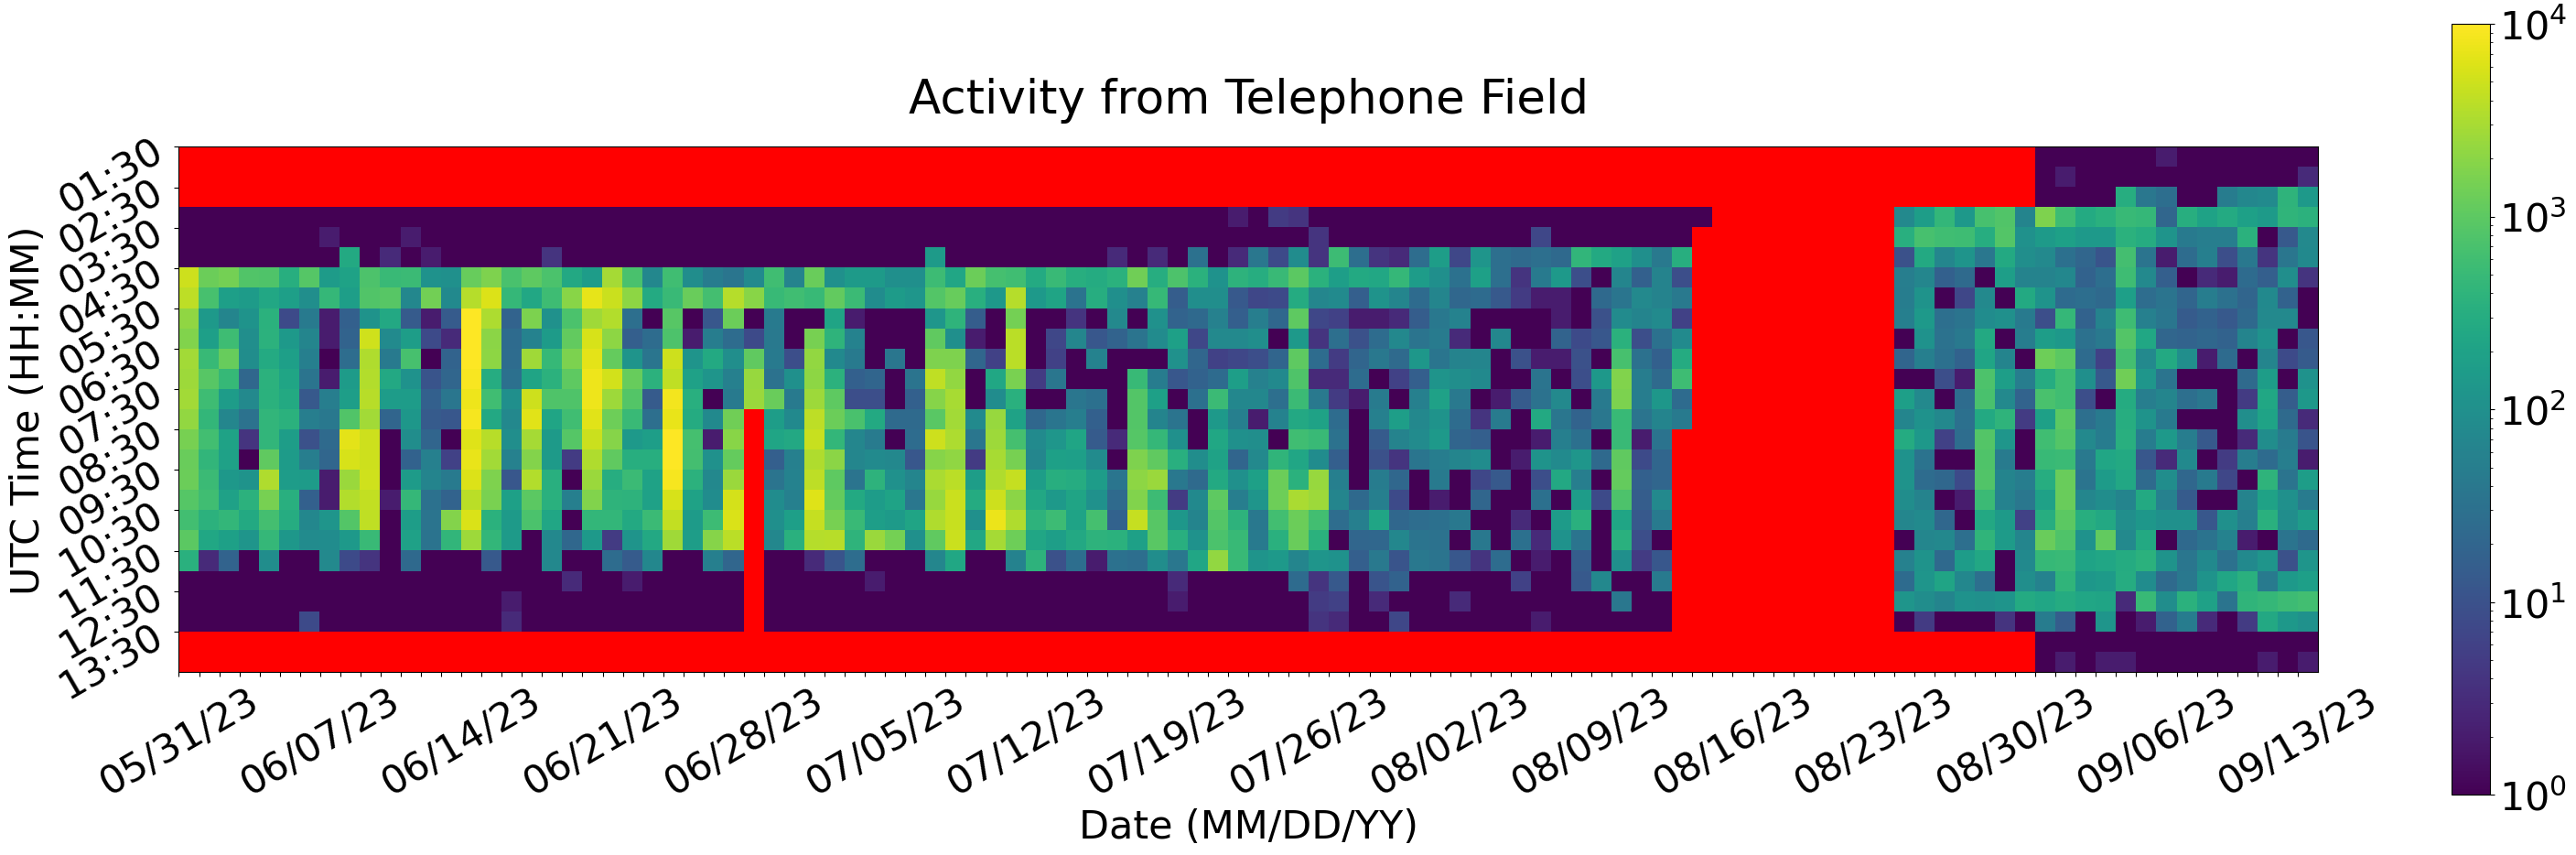

In [37]:
site = "Telephone Field"
cfg["site"] = site
cfg["recording_start"] = '01:30'
cfg["recording_end"] = '14:30'
resample_tag = "30T"

activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg['site'], resample_tag, cfg)
batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg['site'], resample_tag)

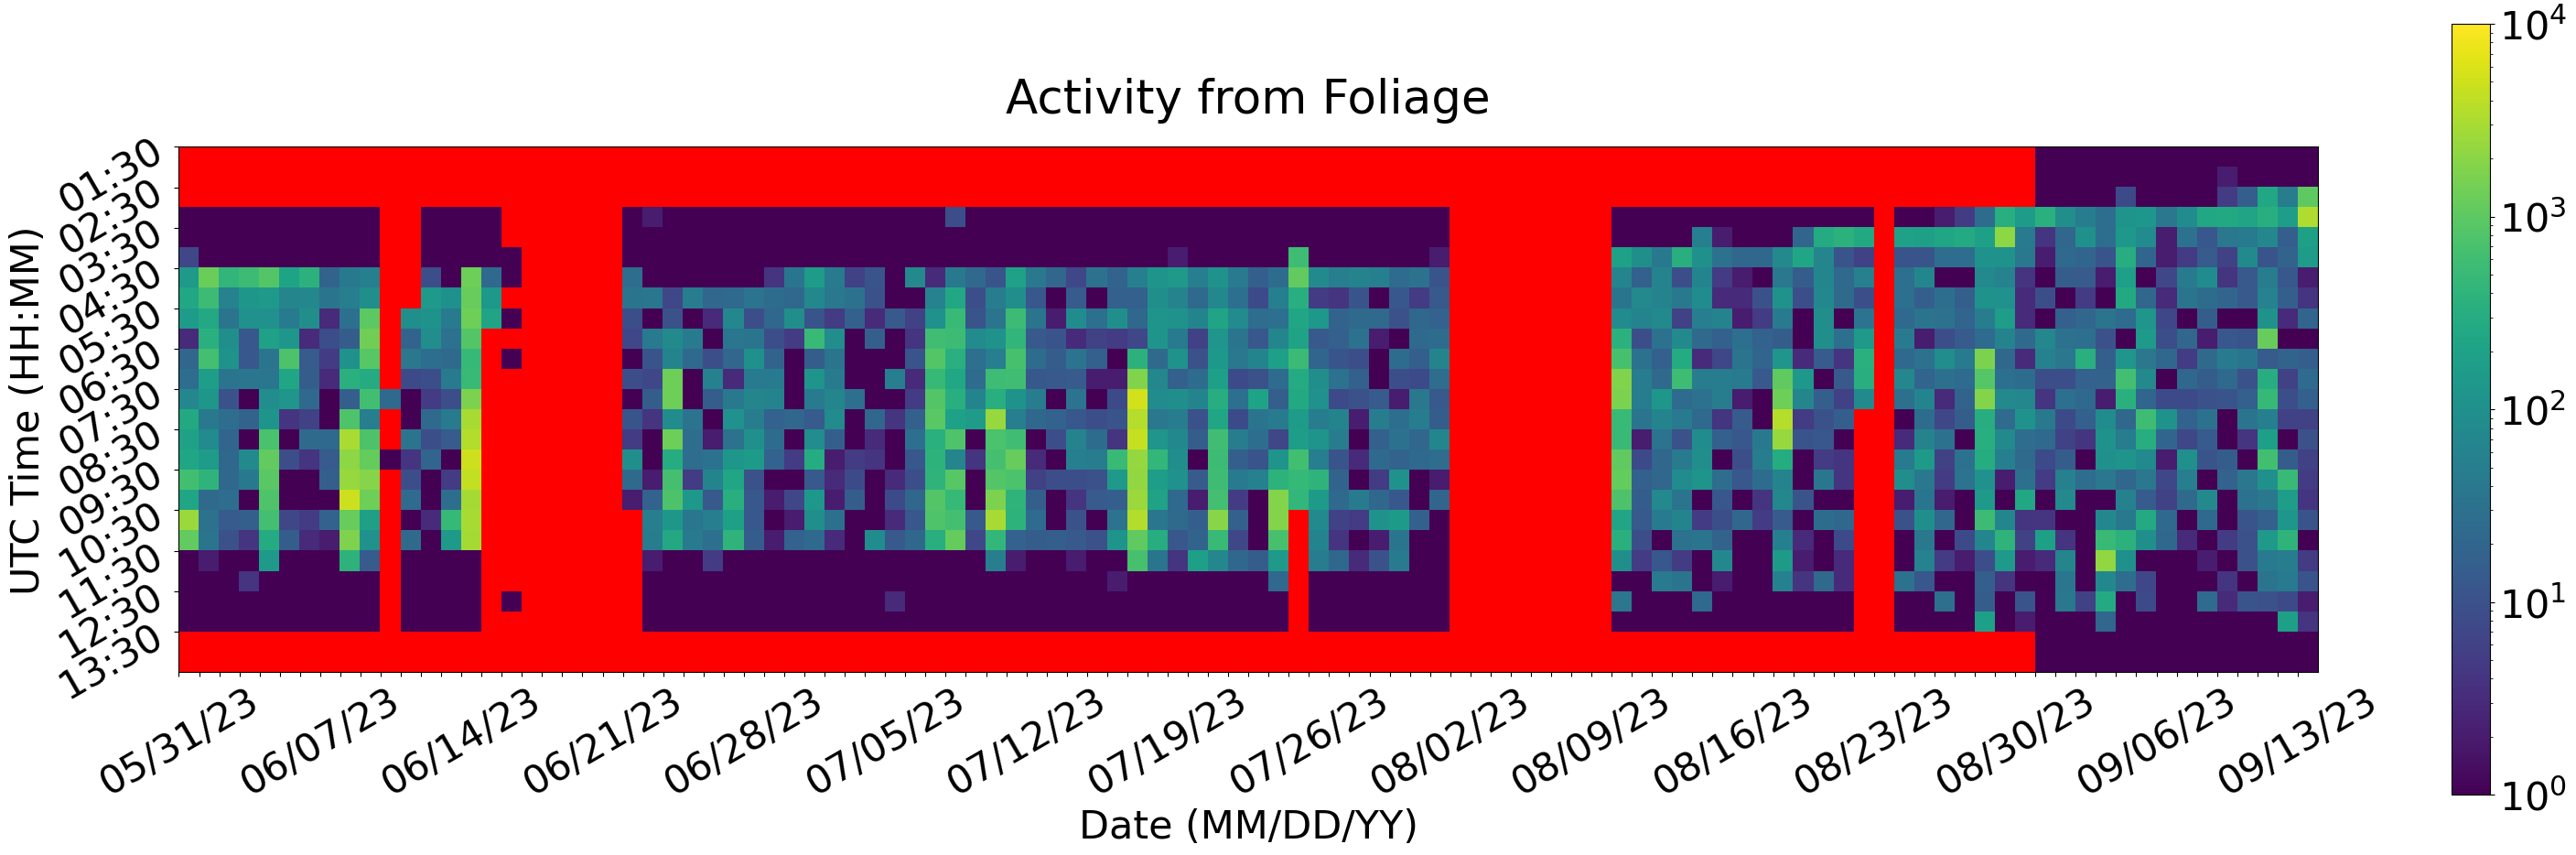

In [38]:
site = "Foliage"
cfg["site"] = site
cfg["recording_start"] = '01:30'
cfg["recording_end"] = '14:30'
resample_tag = "30T"

activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg['site'], resample_tag, cfg)
batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg['site'], resample_tag)

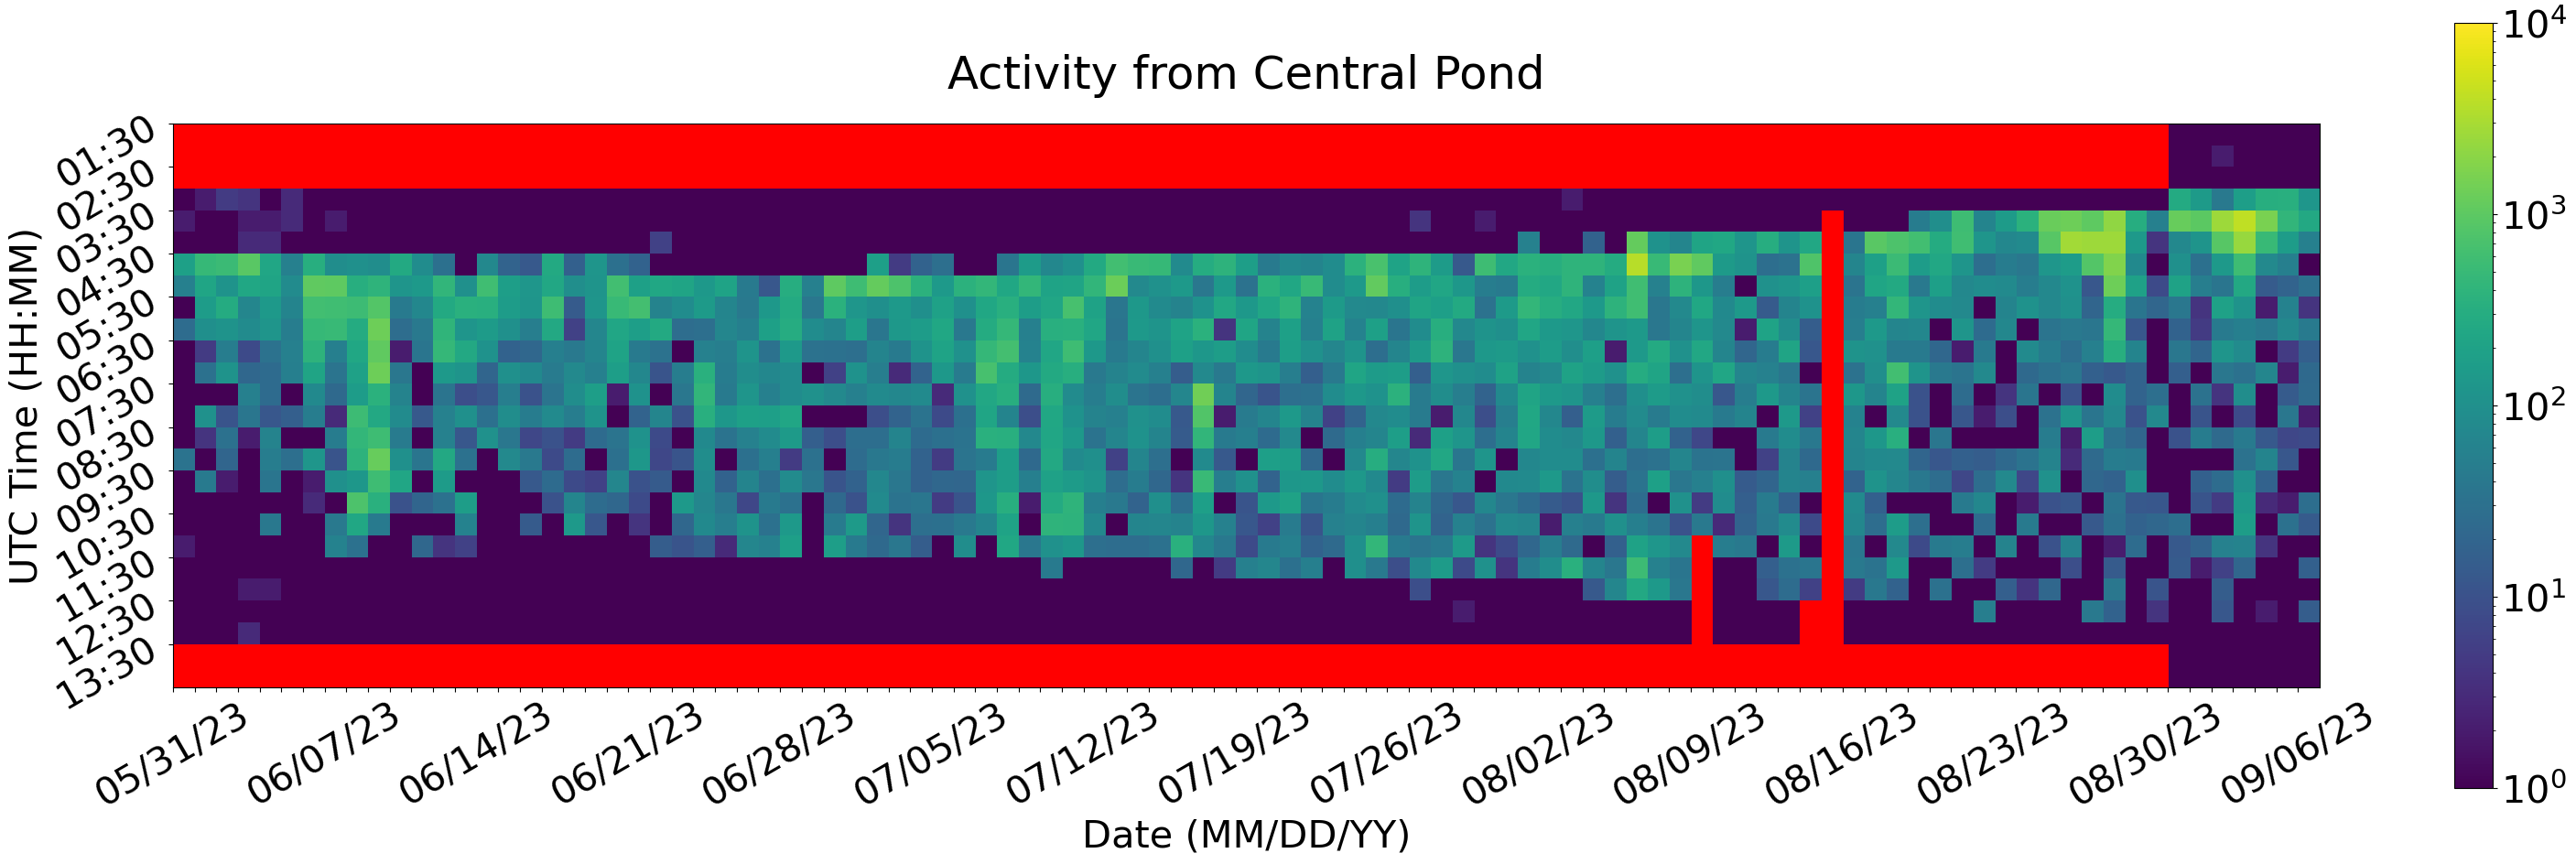

In [39]:
site = "Central Pond"
cfg["site"] = site
cfg["recording_start"] = '01:30'
cfg["recording_end"] = '14:30'
resample_tag = "30T"

activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg['site'], resample_tag, cfg)
batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg['site'], resample_tag)

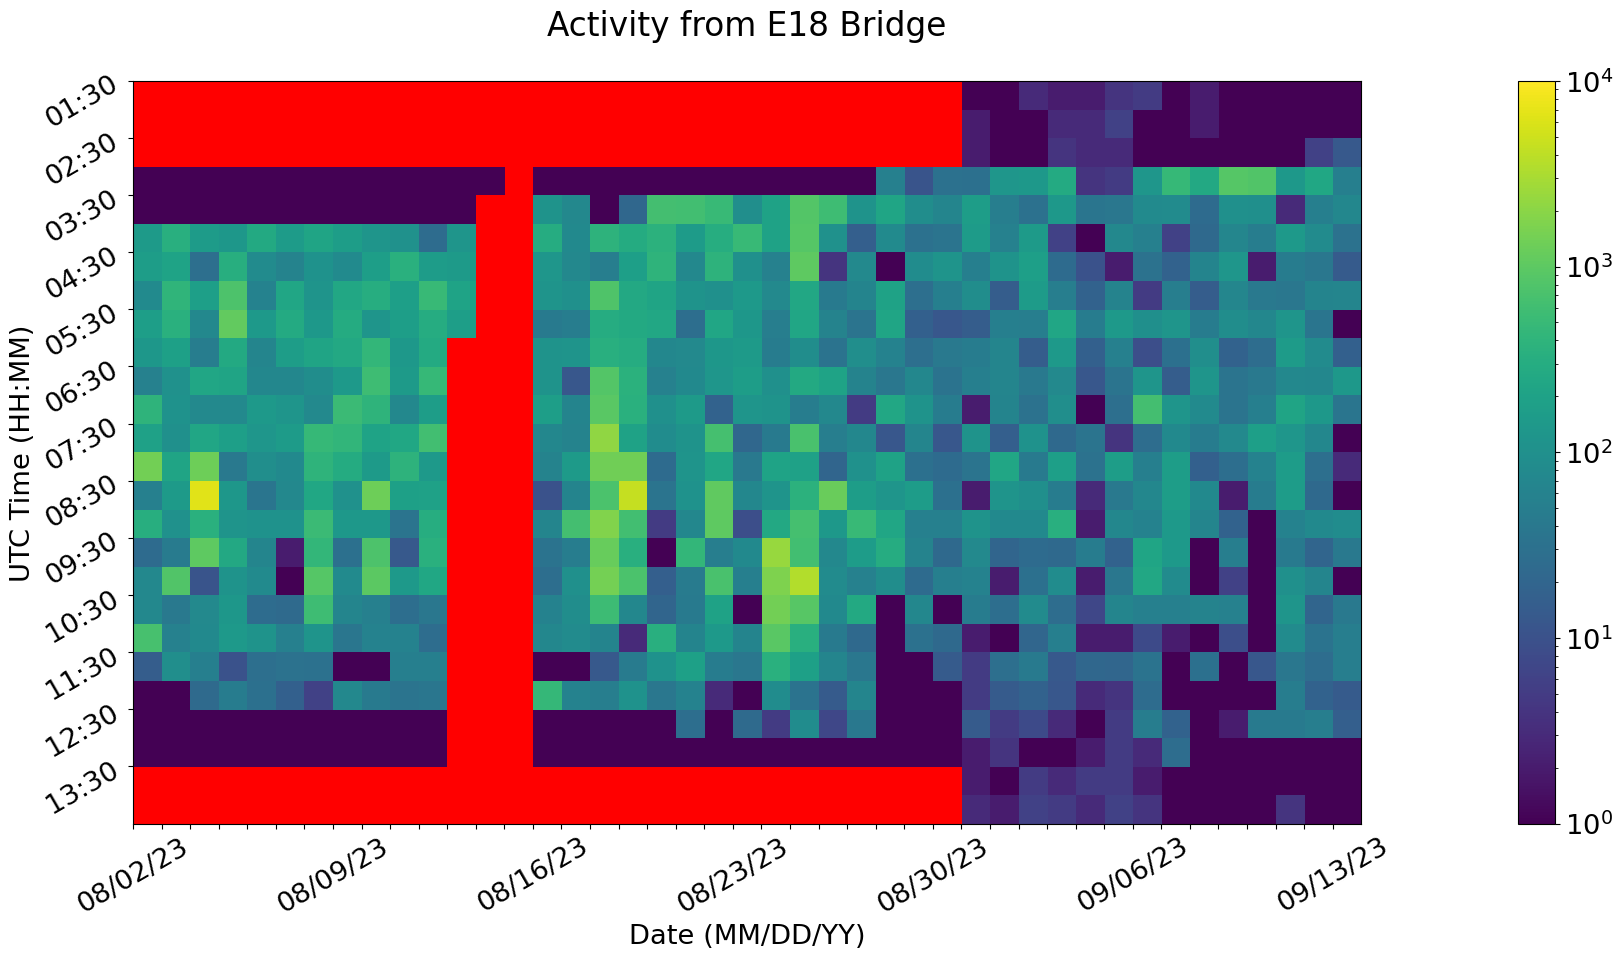

In [40]:
site = "E18 Bridge"
cfg["site"] = site
cfg["recording_start"] = '01:30'
cfg["recording_end"] = '14:30'
resample_tag = "30T"

activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg['site'], resample_tag, cfg)
batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg['site'], resample_tag)